### FINALIZED

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import pickle
import keras
import os, time
from keras import backend as K
from keras.utils import np_utils
from IPython.display import clear_output
import matplotlib.pyplot as plt
from functools import partial
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(int(time.time()))
random.seed(1)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, gpu_options = gpu_options)
tf.set_random_seed(1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [5]:
with open('train.pickle', 'rb') as f:
    X_train, Y_train = pickle.load(f)
    
X_train = X_train.reshape([80647, 5, 5, 1])

In [6]:
IQR = - np.quantile(Y_train, 0.25) + np.quantile(Y_train, 0.75)

In [7]:
lower_bound, upper_bound = np.quantile(Y_train, 0.25) - 1.5 * IQR, np.quantile(Y_train, 0.75) + 1.5 * IQR

In [8]:
idx, val = np.where((Y_train >= lower_bound) & (Y_train <= upper_bound))

In [9]:
Y_train = Y_train[idx]
X_train = X_train[idx]

In [10]:
X_train.shape, Y_train.shape

((78035, 5, 5, 1), (78035, 1))

In [11]:
# Create placeholders
real_data = tf.placeholder(tf.float32, shape = [None, 5, 5, 1])
z = tf.placeholder(tf.float32, shape = [None, 128])
y = tf.placeholder(tf.float32, [None, 1])

In [12]:
np.min(Y_train), np.max(Y_train)

(0.4787, 1.948)

In [13]:
def lrelu(X, leak = 0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

In [14]:
def generator(z, y_, reuse=None):
    with tf.variable_scope('G',reuse=reuse):      
        
        y_ = tf.concat([z, y_], axis = 1)
        
        hidden2 = tf.layers.dense(y_, units = 1 * 1 * 512)
        R1 = tf.reshape(hidden2, shape = [-1,1,1,512])
        
        for i in range(5):
            C1 = tf.layers.conv2d_transpose(R1, filters = 512, kernel_size = 3,
                                            strides = (1, 1), padding = 'same')
            B1 = tf.layers.batch_normalization(C1)
            R1 = lrelu(B1)
        
        C1 = tf.layers.conv2d_transpose(R1, filters = 256, kernel_size = 3,
                                        strides = (2, 2), padding = 'same')
        B1 = tf.layers.batch_normalization(C1)
        R1 = lrelu(B1)
        
        C2 = tf.layers.conv2d_transpose(R1, filters = 128, kernel_size = 3,
                                       strides = (2, 2), padding = 'same')
        B2 = tf.layers.batch_normalization(C2)
        R2 = lrelu(B2)
        
        C3 = tf.layers.conv2d_transpose(R2, filters = 1, kernel_size = 2,
                                       strides = (1, 1))
        O = tf.nn.tanh(C3)
        
        return O

In [15]:
def discriminator(X, y_, reuse=None):
    with tf.variable_scope('D',reuse=reuse):
  
        y1 = tf.concat([X, y_], axis = 1)
        
        y2 = tf.layers.dense(y1, units = 256)
        y2 = lrelu(y2)
        y2 = tf.layers.dropout(y2, 0.5)
        
        yout = tf.layers.dense(y2, units = 1)
        O = tf.nn.sigmoid(yout)
        
        return O

In [16]:
# Regressor for inception score
def regressor(X, reuse = None):
    with tf.variable_scope('R', reuse = reuse):
        tower0 = tf.layers.conv2d(X, filters = 32, kernel_size = (1, 1),
                                 padding = 'same')
        
        tower1 = tf.layers.conv2d(X, filters = 64, kernel_size = (1, 1),
                                 padding = 'same')
        tower1 = tf.layers.conv2d(tower1, filters = 64, kernel_size = (3, 3),
                                 padding = 'same')
        
        tower2 = tf.layers.conv2d(X, filters = 32, kernel_size = (1, 1),
                                 padding = 'same')
        tower2 = tf.layers.conv2d(tower2, filters = 32, kernel_size = (5, 5),
                                 padding = 'same')
        
        tower3 = tf.layers.max_pooling2d(X, pool_size = (3, 3), strides = (1, 1),
                                        padding = 'same')
        tower3 = tf.layers.conv2d(tower3, filters = 32, kernel_size = (1, 1),
                                 padding = 'same')
        
        h = tf.concat([tower0, tower1, tower2, tower3], axis = -1)
        h = tf.nn.relu(h)
        h = tf.layers.max_pooling2d(h, pool_size = (2, 2), strides = (1, 1), padding = 'same')
      
        for i in range(6):
            tower0 = tf.layers.conv2d(h, filters = 32, kernel_size = (1, 1),
                                 padding = 'same')
        
            tower1 = tf.layers.conv2d(h, filters = 64, kernel_size = (1, 1),
                                     padding = 'same')
            tower1 = tf.layers.conv2d(tower1, filters = 64, kernel_size = (3, 3),
                                     padding = 'same')

            tower2 = tf.layers.conv2d(h, filters = 32, kernel_size = (1, 1),
                                     padding = 'same')
            tower2 = tf.layers.conv2d(tower2, filters = 32, kernel_size = (5, 5),
                                     padding = 'same')

            tower3 = tf.layers.max_pooling2d(h, pool_size = (3, 3), strides = (1, 1),
                                            padding = 'same')
            tower3 = tf.layers.conv2d(tower3, filters = 32, kernel_size = (1, 1),
                                     padding = 'same')

            h = tf.concat([tower0, tower1, tower2, tower3], axis = -1)
            h = tf.nn.relu(h)
            if i % 2 == 0 and i != 0:
                h = tf.layers.max_pooling2d(h, pool_size = (2, 2), strides = (1, 1), padding = 'same')
        
        Z0 = tf.layers.flatten(h)
        Z0 = tf.layers.dense(Z0, units = 512, activation = 'relu')
        Z0 = tf.layers.dropout(Z0, 0.2)
        
        Z0 = tf.layers.dense(Z0, units = 32)
        Z_out = Z0

        O = tf.layers.dense(Z0, units = 1)
        
        return O, Z_out

In [17]:
def L2_Loss(y, y_hat):
    return tf.reduce_mean((y - y_hat) ** 2)

def L1_Loss(y, y_hat):
    return tf.reduce_mean(tf.abs(y - y_hat))

In [18]:
fake_data = generator(z, y)

true_pred, true_logit = regressor(real_data)
fake_pred, fake_logit = regressor(fake_data, reuse = True)

true_label_pred = discriminator(true_logit, y)
fake_label_pred = discriminator(fake_logit, y, reuse = True)

gen_sample = generator(z, y, reuse = True)
gen_pred, gen_logit = regressor(gen_sample, reuse = True)

# Regressor helper loss:
R_loss = L2_Loss(true_pred, y)

# Discriminator losses:
D_real_loss = L2_Loss(true_label_pred, 0.9 * tf.ones_like(true_label_pred))
D_fake_loss = L2_Loss(fake_label_pred, tf.zeros_like(fake_label_pred))
D_loss = (D_real_loss + D_fake_loss)/2

# Generator loss:
G_loss = L2_Loss(fake_label_pred, 0.9 * tf.ones_like(fake_label_pred)) + 25 * L2_Loss(fake_pred, y)

# Opimizer
lr = 1e-4

# Getting variables
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'D' in var.name]
g_vars = [var for var in tvars if 'G' in var.name]
r_vars = [var for var in tvars if 'R' in var.name]

# Setting up the optimizers
opt_d = tf.train.AdamOptimizer(learning_rate = lr, beta1 = 0.5).minimize(D_loss, var_list = d_vars)
opt_g = tf.train.AdamOptimizer(learning_rate = lr, beta1 = 0.5).minimize(G_loss, var_list = g_vars)
opt_r = tf.train.AdamOptimizer(learning_rate= lr).minimize(R_loss, var_list = r_vars)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
73.236/1219

0.06007875307629205

Currently on epoch 0 of 256
G Loss: 1.0908817052841187, D Loss: 0.18948087096214294, R Loss: 0.01698073372244835
Current number of unique samples: 1
------------
Currently Generating [[1.8593]]
Predicted bandgap: 1.6938369274139404
Samples not in database :100
------------
-----------
Saving current model
Currently on epoch 10 of 256
G Loss: 0.23051394522190094, D Loss: 0.20087964832782745, R Loss: 0.004045507870614529
Current number of unique samples: 3
------------
Currently Generating [[1.4004]]
Predicted bandgap: 1.397233009338379
Samples not in database :100
------------


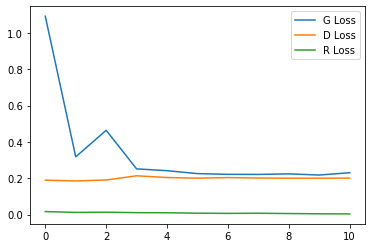

-----------
Saving current model
Currently on epoch 20 of 256
G Loss: 0.21844221651554108, D Loss: 0.19724369049072266, R Loss: 0.004723524674773216
Current number of unique samples: 2
------------
Currently Generating [[0.8658]]
Predicted bandgap: 0.8779079914093018
Samples not in database :100
------------


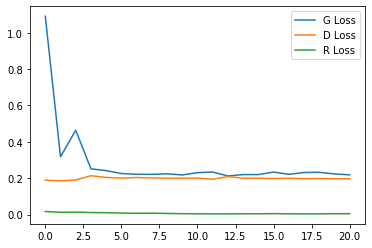

-----------
Saving current model
Currently on epoch 30 of 256
G Loss: 0.21693211793899536, D Loss: 0.19639185070991516, R Loss: 0.002510707126930356
Current number of unique samples: 3
------------
Currently Generating [[1.4596]]
Predicted bandgap: 1.454673171043396
Samples not in database :100
------------


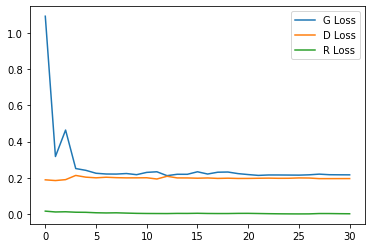

-----------
Saving current model
Currently on epoch 40 of 256
G Loss: 0.22245526313781738, D Loss: 0.19453319907188416, R Loss: 0.0025413604453206062
Current number of unique samples: 4
------------
Currently Generating [[1.3214]]
Predicted bandgap: 1.3152058124542236
Samples not in database :100
------------


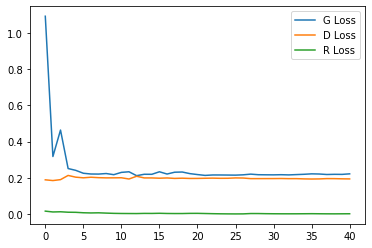

-----------
Saving current model
Currently on epoch 50 of 256
G Loss: 0.22029615938663483, D Loss: 0.1983814537525177, R Loss: 0.0015068029752001166
Current number of unique samples: 2
------------
Currently Generating [[1.8549]]
Predicted bandgap: 1.820641040802002
Samples not in database :100
------------


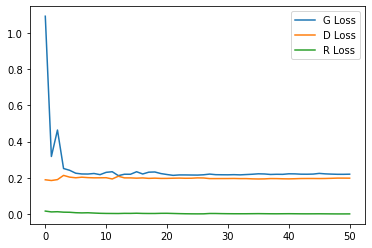

-----------
Saving current model
Currently on epoch 60 of 256
G Loss: 0.22299572825431824, D Loss: 0.19767694175243378, R Loss: 0.0017466099234297872
Current number of unique samples: 2
------------
Currently Generating [[0.9494]]
Predicted bandgap: 0.9666085839271545
Samples not in database :100
------------


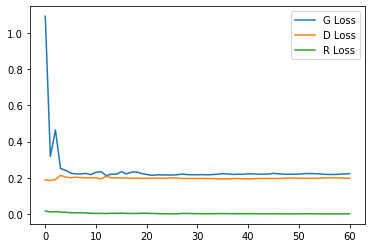

-----------
Saving current model
Currently on epoch 70 of 256
G Loss: 0.22072367370128632, D Loss: 0.19867731630802155, R Loss: 0.001379733090288937
Current number of unique samples: 2
------------
Currently Generating [[1.2276]]
Predicted bandgap: 1.2103164196014404
Samples not in database :100
------------


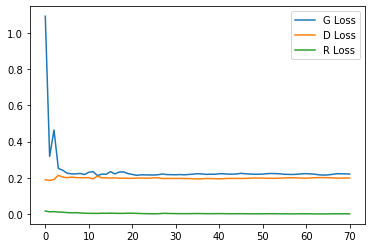

-----------
Saving current model
Currently on epoch 80 of 256
G Loss: 0.21717673540115356, D Loss: 0.2006036788225174, R Loss: 0.0009651595610193908
Current number of unique samples: 2
------------
Currently Generating [[1.1514]]
Predicted bandgap: 1.1607898473739624
Samples not in database :100
------------


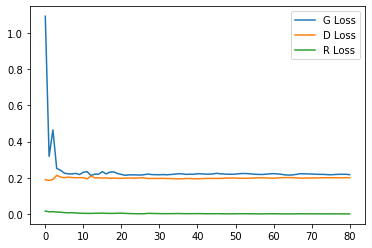

-----------
Saving current model
Currently on epoch 90 of 256
G Loss: 0.2195497453212738, D Loss: 0.2001829296350479, R Loss: 0.001174130360595882
Current number of unique samples: 5
------------
Currently Generating [[1.1279]]
Predicted bandgap: 1.1207804679870605
Samples not in database :100
------------


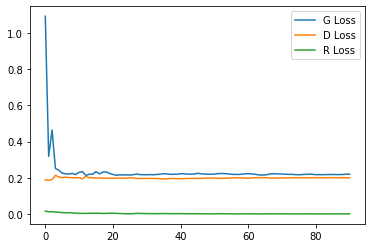

-----------
Saving current model
Currently on epoch 100 of 256
G Loss: 0.2151733636856079, D Loss: 0.20090703666210175, R Loss: 0.0008492088527418673
Current number of unique samples: 3
------------
Currently Generating [[0.7696]]
Predicted bandgap: 0.8038581013679504
Samples not in database :100
------------


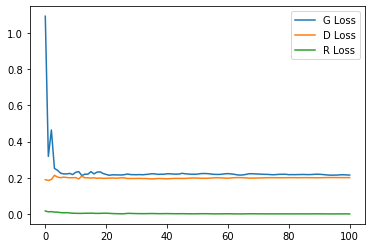

-----------
Saving current model
Currently on epoch 110 of 256
G Loss: 0.21508987247943878, D Loss: 0.2010233998298645, R Loss: 0.0008530315826646984
Current number of unique samples: 3
------------
Currently Generating [[0.7185]]
Predicted bandgap: 0.7288240194320679
Samples not in database :100
------------


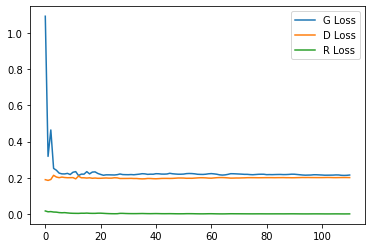

-----------
Saving current model
Currently on epoch 120 of 256
G Loss: 0.21476882696151733, D Loss: 0.20119433104991913, R Loss: 0.0007300396100617945
Current number of unique samples: 3
------------
Currently Generating [[1.1177]]
Predicted bandgap: 1.14271879196167
Samples not in database :100
------------


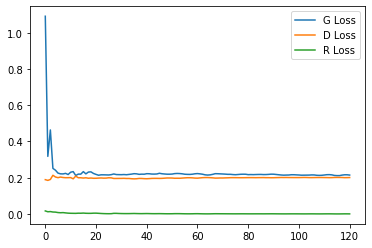

-----------
Saving current model
Currently on epoch 130 of 256
G Loss: 0.21397706866264343, D Loss: 0.20103324949741364, R Loss: 0.0007540572551079094
Current number of unique samples: 5
------------
Currently Generating [[0.871]]
Predicted bandgap: 0.8757418990135193
Samples not in database :100
------------


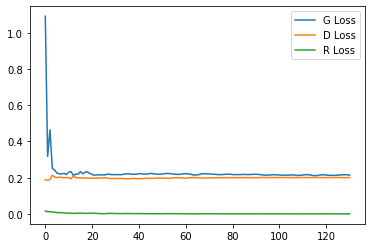

-----------
Saving current model
Currently on epoch 140 of 256
G Loss: 0.21299481391906738, D Loss: 0.20156848430633545, R Loss: 0.0006353664211928844
Current number of unique samples: 3
------------
Currently Generating [[1.7062]]
Predicted bandgap: 1.6992601156234741
Samples not in database :100
------------


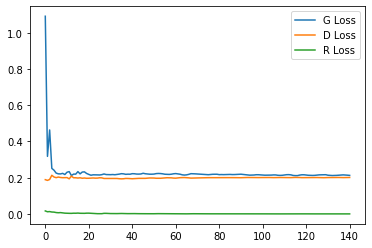

-----------
Saving current model
Currently on epoch 150 of 256
G Loss: 0.2108565866947174, D Loss: 0.20159165561199188, R Loss: 0.0005497806705534458
Current number of unique samples: 2
------------
Currently Generating [[0.9088]]
Predicted bandgap: 0.9235255718231201
Samples not in database :100
------------


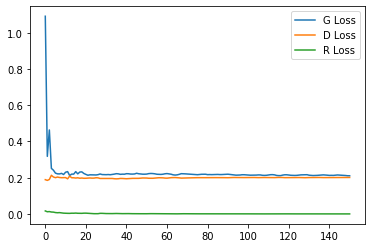

-----------
Saving current model
Currently on epoch 160 of 256
G Loss: 0.21197164058685303, D Loss: 0.20140570402145386, R Loss: 0.0006428966880775988
Current number of unique samples: 1
------------
Currently Generating [[1.6964]]
Predicted bandgap: 1.6963385343551636
Samples not in database :100
------------


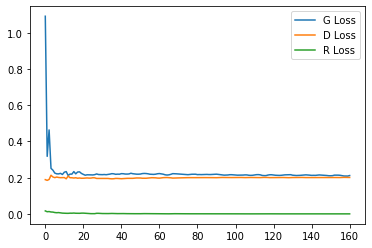

-----------
Saving current model
Currently on epoch 170 of 256
G Loss: 0.2114877998828888, D Loss: 0.2017674744129181, R Loss: 0.0005806992412544787
Current number of unique samples: 1
------------
Currently Generating [[1.8585]]
Predicted bandgap: 1.8722926378250122
Samples not in database :100
------------


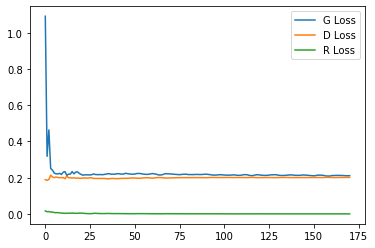

-----------
Saving current model
Currently on epoch 180 of 256
G Loss: 0.21259236335754395, D Loss: 0.20119963586330414, R Loss: 0.0005781676154583693
Current number of unique samples: 5
------------
Currently Generating [[1.2656]]
Predicted bandgap: 1.2868233919143677
Samples not in database :100
------------


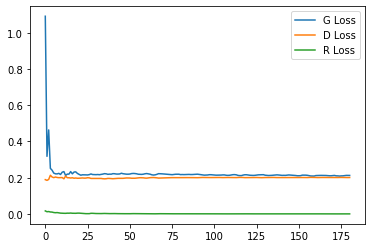

-----------
Saving current model
Currently on epoch 190 of 256
G Loss: 0.2110615223646164, D Loss: 0.20134858787059784, R Loss: 0.00044895661994814873
Current number of unique samples: 3
------------
Currently Generating [[0.8659]]
Predicted bandgap: 0.8906625509262085
Samples not in database :100
------------


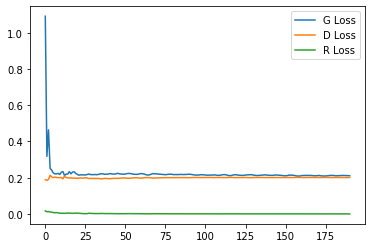

-----------
Saving current model
Currently on epoch 200 of 256
G Loss: 0.21154439449310303, D Loss: 0.20133212208747864, R Loss: 0.0005510778282769024
Current number of unique samples: 1
------------
Currently Generating [[0.6852]]
Predicted bandgap: 0.6915310621261597
Samples not in database :100
------------


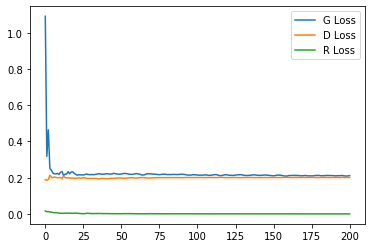

-----------
Saving current model
Currently on epoch 210 of 256
G Loss: 0.21202541887760162, D Loss: 0.1997968554496765, R Loss: 0.0008092036005109549
Current number of unique samples: 3
------------
Currently Generating [[1.1841]]
Predicted bandgap: 1.196600079536438
Samples not in database :100
------------


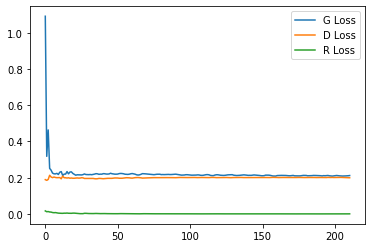

-----------
Saving current model
Currently on epoch 220 of 256
G Loss: 0.210361048579216, D Loss: 0.2010033130645752, R Loss: 0.000549832358956337
Current number of unique samples: 2
------------
Currently Generating [[0.5535]]
Predicted bandgap: 0.581807553768158
Samples not in database :100
------------


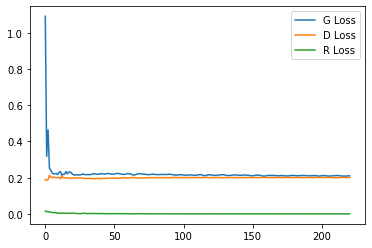

-----------
Saving current model
Currently on epoch 230 of 256
G Loss: 0.2106723040342331, D Loss: 0.20104078948497772, R Loss: 0.00042264978401362896
Current number of unique samples: 3
------------
Currently Generating [[0.638]]
Predicted bandgap: 0.6361410021781921
Samples not in database :100
------------


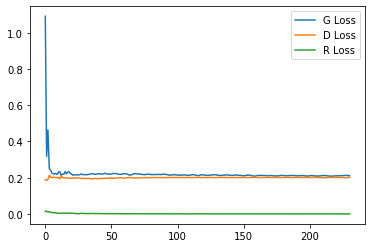

-----------
Saving current model
Currently on epoch 240 of 256
G Loss: 0.207736998796463, D Loss: 0.2017054408788681, R Loss: 0.00034975199378095567
Current number of unique samples: 2
------------
Currently Generating [[0.9538]]
Predicted bandgap: 0.9456529021263123
Samples not in database :100
------------


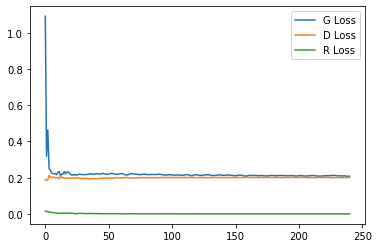

-----------
Saving current model
Currently on epoch 250 of 256
G Loss: 0.20833705365657806, D Loss: 0.2016279399394989, R Loss: 0.00045503737055696547
Current number of unique samples: 1
------------
Currently Generating [[0.8133]]
Predicted bandgap: 0.8326677083969116
Samples not in database :100
------------


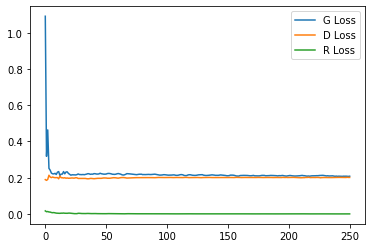

-----------
Saving current model


In [16]:
epochs_gan = 256
batch_size = 64

batches = 78035 // batch_size

D_Losses = []
G_Losses = []
R_Losses = []

saver = tf.train.Saver()
tol_time = 0

with tf.Session(config=session_conf) as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs_gan+1):
        a = time.time()
        D_Losses_ = []
        G_Losses_ = []
        R_Losses_ = []

        for b in range(batches):
            idx = np.arange(b * batch_size, (b + 1) * batch_size)
            train = X_train[idx,:,:,:]
            batch_y = Y_train[idx,:]
            batch_z = np.random.normal(0, 1, size = (batch_size, 128))

            G_loss_, _ = sess.run([G_loss, opt_g], feed_dict = {y: batch_y, z: batch_z})
            R_loss_, _= sess.run([R_loss, opt_r], feed_dict = {real_data: train, y: batch_y})
            D_loss_, _ = sess.run([D_loss, opt_d], feed_dict = {real_data: train, y: batch_y, z: batch_z})
            D_Losses_.append(D_loss_)
            G_Losses_.append(G_loss_)
            R_Losses_.append(R_loss_)
        
        b = time.time()
        delta_t = b - a
        tol_time += delta_t
        
        D_Losses.append(np.mean(D_Losses_))
        G_Losses.append(np.mean(G_Losses_))
        R_Losses.append(np.mean(R_Losses_))
        
        if e % 10 == 0:
            print('Currently on epoch {} of {}'.format(e, epochs_gan))
            print('G Loss: {}, D Loss: {}, R Loss: {}'.format(np.mean(G_Losses_), np.mean(D_Losses_), np.mean(R_Losses_)))
            samples = []
            scores = []
            sample_y = np.random.uniform(0.48, 1.95, size = (1, 1))
            sample_y = np.round(sample_y, 4)
            sample_y_ = sample_y * np.ones([100, 1])
            sample_z = np.random.normal(0, 1, size = (100, 128))
                
            gen_sample_, pred_score = sess.run([gen_sample, gen_pred], feed_dict = {y: sample_y_, z: sample_z})

            samples = np.array(gen_sample_)
            samples = samples.reshape([100,5,5,1])
            samples = np.where(samples < 0, -1, 1)
            
            S_ = samples.tolist()
            not_in = 0
            for s_ in S_:
                if s_ not in X_train.tolist():
                    not_in += 1
            
            print('Current number of unique samples: {}'.format(np.shape(np.unique(samples[:,:,:,0], axis = 0))[0]))
            print('------------')
            print('Currently Generating {}'.format(sample_y))
            print('Predicted bandgap: {}'.format(np.mean(pred_score)))
            print('Samples not in database :{}'.format(not_in))
            print('------------')
            
            if e != 0:
                plt.plot(G_Losses)
                plt.plot(D_Losses)
                plt.plot(R_Losses)
                plt.legend(['G Loss', 'D Loss', 'R Loss'])
                plt.show()

        if e % 10 == 0:
            print('-----------')
            print('Saving current model')
            saver.save(sess, "cGAN_model.ckpt")
            with open('cGAN_Losses.pickle', 'wb') as f:
                pickle.dump((G_Losses, D_Losses, R_Losses), f)

In [17]:
print('average running time: {}'.format(tol_time / 256))

average running time: 73.23594409227371


In [ ]:
saver = tf.train.Saver()
batch_size = 64

batches = 78035 // batch_size
preds = []

with tf.Session(config = session_conf) as sess:
    saver.restore(sess, 'cGAN_model.ckpt')
    print('Model has been loaded!')
    for b in range(batches):
        if b % 50 == 0:
            print('predicting: {}/{}'.format(b, batches))
        
        idx = np.arange(b * batch_size, (b + 1) * batch_size)
        data = X_train[idx,:,:,:]
        predicted, _ = sess.run(regressor(real_data, reuse = True), feed_dict = {real_data: data})
        
        preds.extend(predicted.reshape([-1]))

INFO:tensorflow:Restoring parameters from cGAN_model.ckpt
Model has been loaded!
predicting: 0/1219
predicting: 50/1219
predicting: 100/1219
predicting: 150/1219
predicting: 200/1219
predicting: 250/1219
predicting: 300/1219
predicting: 350/1219
predicting: 400/1219
predicting: 450/1219
predicting: 500/1219
predicting: 550/1219
predicting: 600/1219
predicting: 650/1219
predicting: 700/1219
predicting: 750/1219
predicting: 800/1219
predicting: 850/1219
predicting: 900/1219
predicting: 950/1219
predicting: 1000/1219


In [19]:
preds = np.asarray(preds)
print('Fractional MAE: {}'.format(np.mean(np.abs((preds - Y_train[:78016].reshape([-1])) / Y_train[:78016].reshape([-1])))))

Fractional MAE: 0.04206729962905385


In [22]:
# Create a dataframe for regressor predicted training data

reg_out = {}

reg_out['X'] = []
reg_out['y'] = Y_train[:78016].reshape([-1])
reg_out['y_pred'] = preds

for x in X_train[:78016,:,:,:]:
    xx = int('0b'+''.join(list(np.where(x<0, 0, 1).reshape([-1]).astype(str))), 2)
    reg_out['X'].append(xx)
    
reg_out = pd.DataFrame(reg_out)

In [24]:
reg_out.to_csv('Reg_55_20200103.csv', index = False)

In [19]:
#============================================#
#===============GENERATION===================#

In [22]:
OUT = pd.DataFrame()

saver = tf.train.Saver()

for K in range(5 + 1):
    print('Progress: {}/{}'.format(K, 5))
    with tf.Session(config=config) as sess:
        saver.restore(sess, 'cGAN_model.ckpt')
        print('------------')
        Samples = []
        labels = []
        Inception_scores = []
        gen_preds = []

        for i in range(200):
            labels_pred = []
            sample_y = np.random.uniform(0.45, 2.00, size = (1, 1))
            sample_y = np.round(sample_y, 4)
            sample_y_ = sample_y * np.ones([1000, 1])

            sample_z = np.random.normal(0, 1, size = (1000, 128))
            gen_sample = sess.run(generator(z, y, reuse = True), feed_dict = {z: sample_z, y: sample_y_})

            gen_sample = np.where(gen_sample < 0, -1, 1)
            gen_score = sess.run(R_loss, feed_dict = {real_data: gen_sample, y: sample_y_})

            Inception_scores.extend(list(np.unique(gen_score)))

            gen_pred_,_ = sess.run(regressor(real_data, reuse = True), feed_dict = {real_data: np.unique(gen_sample, axis = 0)})
            gen_preds.append(gen_pred_)

            # print('------------')
            gen_sample = np.array(gen_sample)
            gen_sample = gen_sample.reshape([1000,5,5,1])
            Samples.extend(list(np.unique(gen_sample, axis = 0)))
            labels.extend(list(sample_y * np.ones(shape = (1, np.shape(np.unique(gen_sample[:,:,:,0], axis = 0))[0]))))

    labels_ = []
    for l in labels:
        for j in range(len(l)):
            labels_.append(l[j])
            
    Gen_preds_ = []
    for l in gen_preds:
        for j in range(len(l)):
            Gen_preds_.append(l[j])
            
    Samples_ = np.where(np.array(Samples)<0, 0, 1)
    
    summary = {}
    summary['X'] = []
    summary['require_label'] = []
    summary['predicted_label'] = []

    for s, l, gen_p in zip(Samples_, labels_, Gen_preds_):
        summary['X'].append(int('0b'+''.join(list(s.reshape([25,]).astype('str').tolist())), 2))
        summary['require_label'].append(l)
        summary['predicted_label'].append(gen_p[0])
        
    out = pd.DataFrame(summary)
    out = out.sort_values('X').reset_index().drop('index', axis = 1)

    OUT = pd.concat([OUT, out], axis = 0, ignore_index = True)
    
    with open('summary.pickle', 'wb') as f:
        pickle.dump(OUT, f)

Progress: 0/5
INFO:tensorflow:Restoring parameters from cGAN_model.ckpt
------------
Progress: 1/5
INFO:tensorflow:Restoring parameters from cGAN_model.ckpt
------------
Progress: 2/5
INFO:tensorflow:Restoring parameters from cGAN_model.ckpt
------------
Progress: 3/5
INFO:tensorflow:Restoring parameters from cGAN_model.ckpt
------------
Progress: 4/5
INFO:tensorflow:Restoring parameters from cGAN_model.ckpt
------------
Progress: 5/5
INFO:tensorflow:Restoring parameters from cGAN_model.ckpt
------------


In [23]:
r = OUT.require_label.values
p = OUT.predicted_label.values

print('Fractional MAE: {}'.format(np.mean(np.abs((p - r) / r))))

Fractional MAE: 0.08767840019011998


In [24]:
gen_out = {}

gen_out['X'] = []
gen_out['y_true'] = Y_train.reshape([-1])

for x in X_train:
    xx = int('0b'+''.join(list(np.where(x<0, 0, 1).reshape([-1]).astype(str))), 2)
    gen_out['X'].append(xx)
    
gen_out = pd.DataFrame(gen_out)

In [25]:
OUT = pd.merge(OUT, gen_out, how = 'left')
OUT.fillna(-1, inplace = True)

In [26]:
OUT.to_csv('generated_55_0129.csv', index = False)

In [30]:
OUT.shape

(2090, 4)

In [29]:
len(set(OUT.X.values))

31

In [ ]:
import pickle

with open('summary.pickle', 'rb') as f:
    OUT = pickle.load(f)

In [20]:
#=====================================================#
#========================LOSS=========================#

In [1]:
import pickle
import pandas as pd
import numpy as np

In [2]:
with open('cGAN_Losses.pickle', 'rb') as f:
    G, D, R = pickle.load(f)

In [3]:
Losses = {}
Losses['G Loss'] = np.asarray(G)
Losses['D Loss'] = np.asarray(D)
Losses['R Loss'] = np.asarray(R)

In [4]:
Losses = pd.DataFrame(Losses)

In [5]:
Losses.to_csv('55_Losses_01072020.csv', index = False)